<!-- dom:TITLE: Interpolation  -->
# Interpolation 
<!-- dom:AUTHOR: Anne Kværnø, Markus Grasmair -->
<!-- Author: -->  
**Anne Kværnø, Markus Grasmair**

Date: **Sep 2, 2022**

In [35]:
%matplotlib inline

import numpy as np
from numpy.linalg import solve, norm    # Solve linear systems and compute norms
import matplotlib.pyplot as plt
from scipy import interpolate
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

If you want to have a nicer theme for your jupyter notebook,
download the [cascade stylesheet file tma4320.css](https://www.math.ntnu.no/emner/TMA4320/2022v/notebooks/tma4320.css)
and execute the next cell:

In [36]:
from IPython.core.display import HTML
def css_styling():
    styles = open("tma4320.css", "r").read()
    return HTML(styles)

# Comment out next line and execute this cell to restore the default notebook style 
css_styling();

# Introduction

In this chapter, we will discuss the problem of approximating a function $f$
on some bounded interval $x \in [a,b]$ by a simpler function $p$.
This problem comes in two flavours that are similar enough to be treated
in a unified way.

The first flavour is the case where the function $f$ is only given implicitly,
or has a very complicated form that is not useful for practical considerations.
<!-- Add an example -->
In this case, one possibility for approximating the function is to choose
distinct points $x_i \in [a,b]$ and compute $y_i := f(x_i)$.
Then we try to find a simpler function $p$ on $[a,b]$ such that $p(x_i) = y_i$
for all $x_i$.

The second flavour of the approximation problem is the setting where the
function $f$ itself is unknown, and only distinct measurement data $y_i = f(x_i)$ of the
function at points $x_i$ are available.
In contrast to the first flavour, we are here typically not free to choose
the placement of the measurement points $x_i$ or their number.

Still, we end up in both cases with the problem

**Interpolation problem.**

Given $n+1$ points $(x_i,y_i)_{i=0}^n$. Find a function $p(x)$ out of a given class of functions
satisfying the *interpolation condition*

<!-- Equation labels as ordinary links -->
<div id="eq:intcond"></div>

$$
\begin{equation} 
    \label{eq:intcond} \tag{1}
    p(x_i) = y_i,\qquad i=0,\dotsc, n. 
\end{equation}
$$

The solution $p(x)$ is called the *interpolator*, the $x_i$ values
are called *nodes*, and the points $(x_i,y_i)$ *interpolation points*.



**Example 1:** 
We are given the points

$$
\begin{array}{c|c|c|c}
x_i & 0 & 2/3 & 1 \\ \hline
y_i & 1 & 1/2 & 0 
\end{array},
$$

which we want to approximate with a quadratic polynomial $p$.
The resulting interpolation polynomial can be computed as

$$
p(x)=(-3x^2-x+4)/4.
$$

The $y$-values of this example are chosen such that $y_i=\cos{(\pi x_i/2)}$.  So
$p_2(x)$ can be considered as an approximation to $\cos{(\pi x/2)}$ on the interval
$[0,1]$ by a quadratic polynomial.

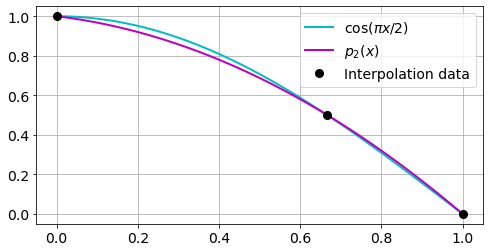

In [37]:
    # Example 1
    xdata = [0,2/3., 1]                    # Interpolation data
    ydata = [1, 1/2., 0]
    x = np.linspace(0,1,100)               # Gridpoints for plotting
    p2 = (-3*x**2-x+4)/4                   # Interpolation polynomial
    f = np.cos(np.pi*x/2)                  # Original function
    plt.plot(x, f, 'c', x, p2, 'm', xdata, ydata, "ok")
    plt.legend(['$\cos(\pi x/2)$', '$p_2(x)$', 'Interpolation data']);

### Content of this note

In this note, we will consider the cases of polynomial interpolation
and spline interpolation.

For polynomial interpolation, we will discuss the following:
* Method: How to compute the polynomials?

* Existence and uniqueness results. 

* Error analysis: If the polynomial is used to approximate a function, how good is the approximation?

* Improvements: If the nodes $x_i$ can be chosen freely, how should we do it in order to reduce the error? 

For splines we will discuss:
* What are splines?

* Implementation and usage in Python.

# Polynomial Interpolation

Let us start with some useful notation and facts about polynomials.  
* A polynomial of degree $n$ is given by

<!-- Equation labels as ordinary links -->
<div id="eq:polynomial"></div>

$$
\begin{equation} \label{eq:polynomial} \tag{2}
 p_n(x) = c_{n}x^n + c_{n-1}x^{n-1} + \cdots + c_1 x_1 + c_0, \qquad  c_i \in
\mathbb{R}, \quad i=0,1,\dotsc,n, \text{ with } c_n\not=0.
\end{equation}
$$

* $\mathbb{P}_n$ is the set of all polynomials of degree at most $n$. 

* $C^m[a,b]$ is the vector space of all continuous functions that have continuous first $m$ derivatives.

* The value $r$ is a *root* or a *zero* of a polynomial $p$ if $p(r)=0$.

* A nonzero polynomial of degree $n$ can never have more than $n$ roots in $\mathbb{R}$ (there may be fewer).  

* A polynomial of degree $n$ with $n$ real roots $r_1,r_2,\dotsc,r_n$ can be written as

$$
p_n(x) = c(x-r_1)(x-r_2)\dotsm(x-r_n) = c_n\prod_{i=1}^n(x-r_i).
$$

## Methods
In this section, we present three techniques for finding the interpolation polynomial for a given set of data. 

### The direct approach

For a polynomial of degree $n$ the interpolation condition ([1](#eq:intcond)) is a linear systems of 
$n+1$ equations in $n+1$ unknowns:

$$
\sum_{i=0}^n x_j^i c_i = y_j, \qquad j=0,\dotsc, n.
$$

If we are basically interested in the polynomials themself, given by the coefficients
$c_i$, $i=0,1,\dotsc, n$, this is a perfectly fine solution.
It is also the strategy implemented in Python's interpolation routines
within the *polynomial* package (see "https://numpy.org/doc/stable/reference/routines.polynomials.html").


**Example 2:**
Given the points

$$
\begin{array}{c|ccccc}
x_i & 0 & 1 & 3 & 4 & 7\\ \hline y_i & 3 & 8 & 6 & -1 & 2
\end{array},
$$

calculate the interpolation polynomial by using the function
*Polynomial.fit* within the *polynomial* package in *numpy*,
and plot the result.

2.9999999999999973 + 6.583333333333392·x¹ - 1.2777777777778074·x² -
0.3611111111111068·x³ + 0.05555555555555538·x⁴


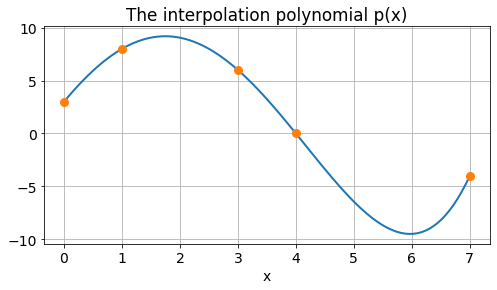

In [38]:
# Example 2

# Define the interpolation points
xdata = [0,1,3,4,7]
ydata = [3,8,6,0,-4]
# Find the degree of the interpolation polynomial
# (that is, one less than the number of interpolation points)
n = np.size(xdata) - 1

# Set the interval
a, b = 0, 7                        # The interpolation interval
x = np.linspace(a, b, 101)         # The 'x-axis'

# Compute the interpolation polynomial using built in numpy functions
p = np.polynomial.Polynomial.fit(xdata,ydata,n)

# Output the polynomial
print(p.convert())

plt.plot(x, p(x))                  # Plot the polynomial
plt.plot(xdata, ydata, 'o')        # Plot the interpolation points 
plt.title('The interpolation polynomial p(x)')
plt.xlabel('x');

If we actually want to solve this problem by hand, we have to solve
the following linear system:

$$
\begin{align*}
c_0  &= 0,\\ 
c_0 + c_1 + c_2 + c_3 + c_4 &= 8,\\ 
c_0 + 3c_1 + 9c_2 + 27c_3 + 81c_4 &= 3,\\ 
c_0 + 4c_1 + 16c_2 + 64c_3 + 256c_4 &= -1,\\ 
c_0 + 7c_1 + 49c_2 + 343c_3 + 2401c_4 &= 2.
\end{align*}
$$

We obtain this system by inserting the given points $(x_i,y_i)$
into the interpolation condition

$$
c_0 + c_1 x + c_2 x^2 + c_3 x^3 + c_4 x^4 = y.
$$

Written in matrix-vector form, the system becomes

$$
\begin{pmatrix}
1 & 0 & 0 & 0 & 0 \\ 
1 & 1 & 1 & 1 & 1 \\ 
1 & 3 & 9 & 27 & 81 \\ 
1 & 4 & 16 & 64 & 256 \\ 
1 & 7 & 49 & 343 & 2401
\end{pmatrix}
\begin{pmatrix}
c_0 \\ c_1 \\ c_2 \\ c_3 \\ c_4
\end{pmatrix}
=
\begin{pmatrix}
0 \\ 8 \\ 3 \\ -1 \\ 2
\end{pmatrix}.
$$

As we can see already from this matrix, the involved numbers become large rather rapidly
as the number of points and the degree of the polynomial increase.

The system becomes even worse if we move the points in this example by 100 to the right,
that is, if we want to interpolate the points

$$
\begin{array}{c|ccccc}
x_i & 100 & 101 & 103 & 104 & 107\\ \hline y_i & 3 & 8 & 6 & -1 & 2
\end{array}
$$

instead. In this case, the entry in the fifth column and fifth row
of the resulting matrix would be $107^4 = 131079601$.
In fact, it is not possible to perform any sensible numerical computations with this matrix:
rounding errors at the level of the machine accuracy will be amplified massively
and will actually influence the numerical solution of the linear system
in a noticeable manner
(in technical terms, we have that the resulting matrix is *ill-conditioned*).
Thus, we have to modify our approach somewhat.

Fortunately, there is a rather straightforward way of mitigating
some of these problems:
We can move the interpolation points ourselves into a "nicer" interval,
for instance the interval $[-1,1]$.
To that end, we define $a := \min_i x_i$ and $b := \max_i x_i$
and use the shift of variables

$$
x_i = \frac{a+b}{2} + t_i \frac{b-a}{2}
$$

or

$$
t_i = \frac{2}{b-a}x_i - \frac{b+a}{b-a}.
$$

This moves all the nodes $x_i$ into the interval $[-1,1]$.
Then we can compute the interpolation polynomial $q$ through the
points $(t_i,y_i)_{i=0}^n$.
Since all the nodes lie between $-1$ and $+1$,
all the entries in the required matrix (all of which are
powers of the nodes) lie between $-1$ and $+1$ as well.
From the polynomial $q$, we can then, if we want to, get back
to an interpolation polynomial $p$ through the points $(x_i,y_i)_{i=0}^n$
by reversing the shift of variables:

$$
p(x) = q(t) = q \Bigl(\frac{2}{b-a}x - \frac{b+a}{b-a}\Bigr).
$$

This strategy of moving the interpolation points to $[-1,1]$ is also implemented
in *numpy*. Calling the function *Polynomial.polynomial.fit* actually results
in the computation of the polynomial $q$. In order to move the polynomial
back to the original interval, we have to use the method *convert*.



### Lagrange interpolation

In this course, polynomial interpolation will be used as a basic tool to
construct other algorithms, in particular for integration.
In that case, the direct approach is not the most convenient option,
so we concentrate on a different strategy,
which essentially makes it possible to just write up the polynomials. 

For $n+1$ points $x_i$, $i = 0,\ldots,n$, with distinct values $x_i \neq x_j$ if $i \neq j$,
the associated *cardinal functions* are defined by:

$$
\ell_i(x) = \prod_{j=0,j\not=i}^n \frac{x-x_j}{x_i-x_j}
  = \frac{x-x_0}{x_i-x_0} \dotsm \frac{x-x_{i-1}}{x_i-x_{i-1}}\cdot \frac{x-x_{i+1}}{x_i-x_{i+1}} \dotsm \frac{x-x_n}{x_i-x_n} , \qquad i=0,\dotsc,n.
$$

The cardinal functions have the following properties:
* $\ell_i \in \mathbb{P}_n$, $i=0,1,\ldots,n$.

* $\ell_i(x_j) = \delta_{ij} = \begin{cases} 1, & \text{when } i=j \\ 0, & \text{when }i\not=j \end{cases}$.

* They are linearly independent, and thus form a basis for $\mathbb{P}_{n}$.

Assume now that we are given points $(x_i,y_i)_{i=0}^n$,
again with distinct $x_i$ values.
The interpolation polynomial is then given by

$$
p_n(x) = \sum_{i=0}^n y_i \ell_i(x),
$$

as

$$
p_n(x_j) = \sum_{i=0}^n y_i \ell_i(x_j) = y_j, \qquad j=0,\dotsc,n.
$$

**Example 3:**
We are given the points

$$
\begin{array}{c|ccc}
x_i & 0 & 1 & 3 \\ \hline y_i & 3 & 8 & 6
\end{array}.
$$

The corresponding cardinal functions are

$$
\begin{align*}
  \ell_0(x) & = \frac{(x-1)(x-3)}{(0-1)(0-3)}
           = \frac{1}{3}x^2-\frac{4}{3}x+1 \\ 
  \ell_1(x) & = \frac{(x-0)(x-3)}{(1-0)(1-3)}
           = -\frac12 x^2 + \frac32 x \\ 
  \ell_2(x) &= \frac{(x-0)(x-1)}{(3-0)(3-1)} = \frac16 x^2-\frac16 x
\end{align*}
$$

and the interpolation polynomial is given by (check it yourself):

$$
p_2(x) = 3 \ell_0(x) + 8 \ell_1(x) + 6 \ell_2(x) = -2x^2 + 7x + 3.
$$

<!-- ===== Implementation ===== -->
The method above is implemented as two functions:
* `cardinal(xdata, x)`: Create a list of cardinal functions $\ell_i(x)$ evaluated in $x$.

* `lagrange(ydata, l)`: Create the interpolation polynomial $p_n(x)$.

Here, `xdata` and `ydata` are arrays with the interpolation points, and `x` is an 
array of values in which the polynomials are evaluated. 

You are not required to understand the implementation of these functions, but you should understand how to use them.

In [5]:
def cardinal(xdata, x):
    """
    cardinal(xdata, x): 
    In: xdata, array with the nodes x_i.
        x, array or a scalar of values in which the cardinal functions are evaluated.
    Return: l: a list of arrays of the cardinal functions evaluated in x. 
    """
    n = len(xdata)              # Number of evaluation points x
    l = []
    for i in range(n):          # Loop over the cardinal functions
        li = np.ones(len(x))
        for j in range(n):      # Loop to make the product for l_i
            if i is not j:
                li = li*(x-xdata[j])/(xdata[i]-xdata[j])
        l.append(li)            # Append the array to the list            
    return l

def lagrange(ydata, l):
    """
    lagrange(ydata, l):
    In: ydata, array of the y-values of the interpolation points.
         l, a list of the cardinal functions, given by cardinal(xdata, x)
    Return: An array with the interpolation polynomial. 
    """
    poly = 0                        
    for i in range(len(ydata)):
        poly = poly + ydata[i]*l[i]  
    return poly

**Example 4:**
Test the functions on the interpolation points of Example 3.

In [6]:
# Example 4
xdata = [0, 1, 3]               # The interpolation points
ydata = [3, 8, 6]
x = np.linspace(0, 3, 101)      # The x-values in which the polynomial is evaluated
l = cardinal(xdata, x)          # Find the cardinal functions evaluated in x
p = lagrange(ydata, l)          # Compute the polynomial evaluated in x
plt.plot(x, p)                  # Plot the polynomial
plt.plot(xdata, ydata, 'o')     # Plot the interpolation points 
plt.title('The interpolation polynomial p(x)')
plt.xlabel('x');

**Numerical exercises:**
1. Plot the cardinal functions for the nodes of Example 1. 

2. Plot the interpolation polynomials for some points of your own choice.

In [7]:
# Insert your code here (use "+" in the Toolbar menu for more cells)

<!-- % if FORMAT in ("latex","pdflatex"): -->
<!-- \newpage -->
<!-- % endif -->

### Newton Interpolation

This is an alternative approach to find the interpolation polynomial.
In the following, we will assume that $y_i=f(x_i)$ for some given function $f(x)$. 

Let $x_0,\,x_1,\ldots,x_n$ be $n+1$ distinct real numbers.
The so-called *Newton form* of a polynomial of degree $n$ is an expansion of the form

$$
p_n(x)=\sum_{i=0}^{n-1} c_{n-i}\prod_{j=0}^{n-1-i}(x-x_j) + c_0,
$$

or more explicitly

$$
p_n(x)=c_n (x-x_0)(x-x_1)\cdots(x-x_{n-1}) + c_{n-1}(x-x_0)(x-x_1)\cdots(x-x_{n-2}) + \cdots + c_1(x-x_0) + c_0.
$$

In the light of this form of writing a polynomial, the polynomial interpolation problem
leads to the following observations:
Let us start with a single node $x_0$, then $f(x_0)=p(x_0)=c_0$.
We go one step further and consider two nodes $x_0$, $x_1$.
Then we see that $f(x_0)=p(x_0)=c_0$ and $f(x_1)=p(x_1)=c_0 + c_1(x_1-x_0)$.
The latter implies that the coefficient $c_1$ is given as

$$
c_1=\frac{f(x_1)-f(x_0)}{x_1-x_0}.
$$

Given three nodes $x_0$, $x_1$, $x_2$, we obtain
the coefficients $c_0$, $c_1$ as defined above, and from the equation

$$
f(x_2)=p_n(x_2)=c_0 +  c_1(x_2-x_0) +  c_2(x_2-x_0)(x_2-x_1)
$$

we deduce the coefficient

$$
c_2=\frac{f(x_2) - f(x_0) - \frac{f(x_1)-f(x_0)}{x_1-x_0} (x_2-x_0)}{(x_2-x_0)(x_2-x_1)}.
$$

Playing with this quotient gives the much more structured expression

$$
c_2=\frac{\frac{f(x_2)-f(x_1)}{x_2-x_1} - \frac{f(x_1)-f(x_0)}{x_1-x_0}}{(x_2-x_0)}.
$$

This procedure can be continued and yields a so-called triangular
system that permits to define the remaining coefficients $c_3,\ldots,c_n$.
One sees quickly that the coefficient $c_k$ only depends on the
interpolation points $(x_0,y_0),\ldots,(x_k,y_k)$, where $y_i:=f(x_i)$, $i=0,\ldots,n$.

We introduce the following so-called finite difference notation for a function $f$.
The 0th order finite difference is defined to be $f[x_0]:=f(x_0)$.
The 1st order finite difference is

$$
f[x_0,x_1]:=\frac{f(x_1)-f(x_0)}{x_1-x_0}.
$$

The second order finite difference is defined as

$$
f[x_0,x_1,x_2]:= \frac{f[x_1,x_2] - f[x_0,x_1]}{x_2-x_0}.
$$

In general, the $k$th order finite difference of the function $f$ is defined to be

$$
f[x_0,\ldots,x_k]:= \frac{f[x_1,\ldots,x_k] - f[x_0,\ldots,x_{k-1}]}{x_k-x_0}.
$$

Newton's method to solve the polynomial interpolation problem can be summarized as follows:
We are given $n+1$ interpolation points $(x_0,y_0),\ldots,(x_n,y_n)$, $y_i:=f(x_i)$.
If the order $n$ interpolation polynomial is expressed in Newton's form

$$
p_n(x)=c_n (x-x_0)(x-x_1)\cdots(x-x_{n-1}) + c_{n-1}(x-x_0)(x-x_1)\cdots(x-x_{n-2}) + \cdots + c_1(x-x_0) + c_0,
$$

then the coefficients

$$
c_k = f[x_0,\ldots,x_k]
$$

for $k=0,\ldots,n$. In fact, a recursion is in place:

$$
p_n(x)=p_{n-1}(x) + f[x_0,\ldots,x_n](x-x_0)(x-x_1)\cdots(x-x_{n-1})
$$

It is common to write the finite differences in a table, which for $n=3$ will
have the form

$$
\begin{array}{c|cccc}
x_0 & f[x_0] & \\ 
    &        & f[x_0,x_1] & \\ 
x_1 & f[x_1] &            & f[x_0,x_1,x_2] \\ 
    &        & f[x_1,x_2] &                & f[x_0,x_1,x_2, x_3] \\ 
x_2 & f[x_2] &            & f[x_1,x_2,x_3] \\ 
    &        & f[x_2,x_3] & \\ 
x_3 & f[x_3] \\ 
\end{array}
$$

**Example 1 again:**
We are given the points in Example 1. The corresponding table of divided differences
becomes

$$
\begin{array}{c|cccc}
0 & 1 & \\ 
    &        & -3/4 & \\ 
2/3 & 1/2 &            &  -3/4 \\ 
    &        & -3/2 &   \\ 
1   & 0 &            
\end{array}
$$

and the interpolation polynomial becomes

$$
p_2(x) = 1 - \frac{3}{4}(x-0)-\frac{3}{4}(x-0)(x-\frac23) =  1 - \frac{1}{4}x -
\frac{3}{4} x^2.
$$

<!-- ===== Implementation ===== -->

The method above is implemented as two functions:
* `divdiff(xdata, ydata)`: Create the table of divided differences

* `newtonInterpolation(F, xdata, x)`: Evaluate the interpolation polynomial.

Here, `xdata` and `ydata` are arrays with the interpolation points, and `x` is an 
array of values in which the polynomial is evaluated.

In [8]:
def divdiff(xdata,ydata):
    '''
    Create the table of divided differences based
    on the data in the arrays x_data and y_data. 
    '''
    n = len(xdata)
    F = np.zeros((n,n))
    F[:,0] = ydata             # Array for the divided differences
    for j in range(n):
        for i in range(n-j-1):
            F[i,j+1] = (F[i+1,j]-F[i,j])/(xdata[i+j+1]-xdata[i])
    return F                    # Return all of F for inspection. 
                                # Only the first row is necessary for the
                                # polynomial.

def newton_interpolation(F, xdata, x):
    # The Newton interpolation polynomial evaluated in x. 
    n, m = np.shape(F)
    xpoly = np.ones(len(x))               # (x-x[0])(x-x[1])...
    newton_poly = F[0,0]*np.ones(len(x))  # The Newton polynomial
    for j in range(n-1):
        xpoly = xpoly*(x-xdata[j])
        newton_poly = newton_poly + F[0,j+1]*xpoly
    return newton_poly

Run the code on the example above:

In [9]:
# Example: Use of divided differences and the Newton interpolation
# formula. 
xdata = [0, 2/3, 1]
ydata = [1, 1/2, 0]
F = divdiff(xdata, ydata)       # The table of divided differences
print('The table of divided differences:\n',F)

x = np.linspace(0, 1, 101)      # The x-values in which the polynomial is evaluated
p = newton_interpolation(F, xdata, x)
plt.plot(x, p)                  # Plot the polynomial
plt.plot(xdata, ydata, 'o')     # Plot the interpolation points 
plt.title('The interpolation polynomial p(x)')
plt.grid(True)
plt.xlabel('x');

## Theoretical Results


### Existence and Uniqueness

We have already proved the existence of such polynomials, simply by constructing
them. But are they unique? The answer is yes! 

**Theorem: Existence and uniqueness of interpolation polynomials:**

Given $n+1$ points $(x_i,y_i)_{i=0}^n$ with distinct $x$ values. Then there is
one and only one polynomial $p_n(x) \in \mathbb{P}_n$ satisfying the
interpolation condition

$$
p_n(x_i) = y_i, \qquad i=0,\dotsc, n.
$$

*Proof:* Suppose there exist two different interpolation polynomials $p_n$ and $q_n$ of
degree $n$ interpolating the same $n+1$ points. The polynomial $r(x) = p_n(x)-q_n(x)$ is of degree $n$
with zeros in all the nodes $x_i$, that is a total of $n+1$ zeros. But then
$r\equiv 0$, thus the two polynomials $p_n$ and $q_n$ are identical. 

### Error Analysis

Given some function $f\in C[a,b]$, choose $n+1$ distinct nodes in
$[a,b]$ and let $p_n(x) \in \mathbb{P}_n$ satisfy the interpolation condition

$$
p_n(x_i) = f(x_i), \qquad i=0,\dots,n.
$$

What can be said about the error $e(x)=f(x)-p_n(x)$? 

Let us start with an numerical experiment, to have a feeling of what to expect. 

**Example 5:**

Let $f(x)=\sin(x)$, $x\in [0,2\pi]$. Choose $n+1$ equidistributed nodes,
that is $x_i=ih$, $i=0,\dots,n$, and $h=2\pi/n$.
Calculate the interpolation polynomial (using whatever 


by use of the functions `cardinal` and `lagrange`. Plot the error $e_n(x)=f(x)-p_n(x)$ for different values of $n$. Choose  $n=4,8,16$ and $32$.  Notice how the error is distributed over the interval, and find the maximum error $\max_{x\in[a,b]}|e_n(x)|$ for each $n$.

In [10]:
# Example 4
xdata = [0, 1, 3]               # The interpolation points
ydata = [3, 8, 6]
x = np.linspace(0, 3, 101)      # The x-values in which the polynomial is evaluated
l = cardinal(xdata, x)          # Find the cardinal functions evaluated in x
p = lagrange(ydata, l)          # Compute the polynomial evaluated in x
plt.plot(x, p)                  # Plot the polynomial
plt.plot(xdata, ydata, 'o')     # Plot the interpolation points 
plt.title('The interpolation polynomial p(x)')
plt.xlabel('x');

**Numerical exercise:**
Repeat the experiment with Runge's function

$$
f(x) = \frac{1}{1+x^2}, \qquad x\in [-5,5].
$$

In [11]:
# Insert your code here

### Interpolation Error

An expression for the interpolation error $f(x)-p(x)$ is given by the following theorem:

**Theorem: Interpolation error.**

Given $f \in C^{(n+1)}[a,b]$. Let $p_{n} \in \mathbb{P}_n$ interpolate $f$ in
$n+1$ distinct nodes $x_i \in [a,b]$. For each $x\in [a,b]$ there is at least
one $\xi(x) \in (a,b)$ such that

$$
f(x) - p_n(x) = \frac{f^{(n+1)}(\xi(x))}{(n+1)!}\prod_{i=0}^n(x-x_i).
$$

*Proof:*
Start by assuming $f$ to be *sufficiently differentialable*, what this is will be revealed on the go. 
We will also need the following function, defined solely by the nodes:

$$
\omega(x) = \prod_{i=0}^{n}(x-x_i) = x^{n+1} + \dotsm.
$$

Obviously, in the nodes $x_i$ there are no error, thus $e(x_i)=0$, $i=0,\dotsc,n$. 
Choose an *arbitrary* $x\in [a,b]$, $x\in [a,b]$, where $x\not=x_i$,
$i=0,1,\dotsc,n$. For this fixed $x$, define a function in $t$ as:

$$
\varphi(t) = e(t)\omega(x) - e(x)\omega(t).
$$

where $e(t) = f(t)-p_n(t)$.
Notice that $\varphi(t)$ is as differentiable with respect to $t$ as $f(t)$. The
function $\varphi(t)$ has $n+2$ distinct zeros (the nodes and the fixed $x$). As a
consequence of Rolle's theorem (see Preliminaries, *Some other useful results*)
the derivative $\varphi'(t)$ has at least $n+1$ distinct zeros, one between each of the zeros
of $\varphi(t)$. So $\varphi''(t)$ has $n$ distinct
zeros, etc. By repeating this argument, we can see that $\varphi^{n+1}(t)$
has at least one zero in $[a,b]$, let us call this $\xi(x)$, as it do depend on the fixed $x$. 
 Since
$\omega^{(n+1)}(t)=(n+1)!$ and $e^{(n+1)}(t)=f^{(n+1)}(t)$ we can conclude that

$$
\varphi^{(n+1)}(\xi)= 0 = f^{(n+1)}(\xi)\omega(x) - e(x)(n+1)!.
$$

Solving this with respect to $e(x)$ gives the statement of the theorem. 

The interpolation error consists of three elements: The derivative of the
function $f$, the number of interpolation points $n+1$ and the distribution of
the nodes $x_i$. We cannot do much with the first of these, but we can choose
the two others. Let us first look at the most obvious choice of nodes.

### Equidistributed nodes

The nodes are *equidistributed* over the interval $[a,b]$ if $x_i=a+ih$, $h=(b-a)/n$. In this case it can
be proved that:

$$
|\omega(x)| \leq \frac{h^{n+1}}{4}n!
$$

such that

$$
|e(x)| \leq \frac{h^{n+1}}{4(n+1)}M, \qquad M=\max_{x\in[a,b]}|f^{(n+1)}(x)|.
$$

for all $x\in [a,b]$. 

Let us now see how good this error bound is by an example.

**Example 6:**
Let again $f(x)=\sin(x)$ on the interval $[0,2\pi]$ and $p_n(x)$ the polynomial interpolating $f(x)$ in
$n+1$ equidistributed points. Find an upper bound for the error for different values of $n$. 

Clearly,
$\max_{x\in[0,2\pi]}|f^{(n+1)}(x)|=M=1$ for all $n$, so

$$
|e_n(x)| = |f(x)-p_n(x)| \leq
\frac{1}{4(n+1)}\left(\frac{2\pi}{n}\right)^{n+1}, \qquad x\in[a,b].
$$

Use the code in Example 5 to verify the result. How close is the bound to the real error? 

## Optimal choice of interpolation points
If you have done the exercise with Runge's function, you should have noted, that the interpolation polynomial with equidistant interpolation points in this case appears not to converge to the function  𝑓
f. Instead the error becomes larger and the approximation worse as the degree increases. Therefore we are interested in finding alternatives that yield a better approximation.


So how can the error be reduced? For a given $n$ there is only one choice: to
distribute the nodes in order to make
$|\omega(x)|= \prod_{j=0}^{n}|x-x_i|$ as small as possible. We will first do this
on a standard interval $[-1,1]$, and then transfer the results to some arbitrary
interval $[a,b]$.

Let us start taking a look at $\omega(x)$ for equidistributed nodes on the
interval $[-1,1]$, for
different values of $n$:

In [12]:
def omega(xdata, x):
    # compute omega(x) for the nodes in xdata
    n1 = len(xdata)
    omega_value = np.ones(len(x))             
    for j in range(n1):
        omega_value = omega_value*(x-xdata[j])  # (x-x_0)(x-x_1)...(x-x_n)
    return omega_value

In [13]:
# Plot omega(x) 
n = 8                           # Number of interpolation points is n+1
a, b = -1, 1                    # The interval
x = np.linspace(a, b, 501)        
xdata = np.linspace(a, b, n) 
plt.plot(x, omega(xdata, x))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('omega(x)')
print("n = {:2d}, max|omega(x)| = {:.2e}".format(n, max(abs(omega(xdata, x)))))

Run the code for different values of $n$. Notice the following: 
* $\max_{x\in[-1,1]} |\omega(x)|$ becomes smaller with increasing $n$. 

* $|\omega(x)|$ has its maximum values near the boundaries of $[-1, 1]$.

A a consequence of the latter, it seems reasonable to move the nodes towards the boundaries. 
It can be proved that the optimal choice of nodes are the *Chebyshev-nodes*, given by

$$
\tilde{x}_i = \cos \left( \frac{(2i+1)\pi}{2(n+1)} \right), \qquad i=0,\dotsc,n
$$

Let $\omega_{Cheb}(x) = \prod_{j=0}^n(x-\tilde{x}_i)$. It is then possible to prove that

$$
\frac{1}{2^{n}} = \max_{x\in [-1, 1]} |\omega_{Cheb}(x)| \leq \max_{x \in [-1, 1]} |q(x)|
$$

for all polynomials $q\in \mathbb{P}_{n+1}$ such that $q(x)=x^{n+1} + c_{n}x^{n}+\dotsm+c_1x + c_0$. 

The distribution of nodes can be transferred to an interval $[a,b]$ by the linear transformation

$$
x = \frac{b-a}{2}\tilde{x} + \frac{b+a}{2}
$$

where $x\in[a,b]$ and $\tilde{x} \in [-1,1]$. By doing so we get

$$
\omega(x) = \prod_{i=0}^n (x-x_i) =
  \left(\frac{b-a}{2}\right)^{n+1} \prod_{i=0}^n (\tilde{x}-\tilde{x}_i)
  = \left(\frac{b-a}{2}\right)^{n+1} \omega_{Cheb}(\tilde{x}).
$$

From the theorem on interpolation errors we can conclude:

**Theorem (interpolation error for Chebyshev interpolation).**

Given $f \in C^{(n+1)}[a,b]$, and let $M_{n+1} = \max_{x\in [a,b]}|f^{(n+1)}(x)|$.  Let $p_{n} \in \mathbb{P}_n$ interpolate $f$ i $n+1$ Chebyshev-nodes $x_i \in [a,b]$. Then

$$
\max_{x\in[a,b]}|f(x) - p_n(x)| \leq \frac{(b-a)^{n+1}}{2^{2n+1}(n+1)!} M_{n+1}.
$$

The Chebyshev nodes over an interval $[a,b]$ are evaluated in the following function:

In [14]:
def chebyshev_nodes(a, b, n):
    # n Chebyshev nodes in the interval [a, b] 
    i = np.array(range(n))                 # i = [0,1,2,3, ....n-1]
    x = np.cos((2*i+1)*pi/(2*(n)))         # nodes over the interval [-1,1]
    return 0.5*(b-a)*x+0.5*(b+a)           # nodes over the interval [a,b]

**Numerical exercises:**
1. Plot $\omega_{Cheb}(x)$ for $3, 5, 9, 17$ interpolation points.

2. Repeat Example 3 using Chebyshev interpolation on the functions below. Compare with the results you got from equidistributed nodes.

$$
\begin{align*}
  f(x) &= \sin(x), && x\in[0,2\pi] \\ 
  f(x) &= \frac{1}{1+x^2}, && x\in[-5,5]. 
\end{align*}
$$

In [15]:
# Insert your code here

**For information**: 
[Chebfun](http://www.chebfun.org/) is software package which makes it possible to manipulate functions and to solve equations with accuracy close to machine accuracy. The algorithms are based on polynomial interpolation in Chebyshev nodes.


# Spline Interpolation

## Idea of Splines

The results we have obtained above have shown that we obtain the
best results for polynomial interpolation, if we use the
Chebyshev interpolation points.
Instead, if we use equidistant interpolation points, the resulting
interpolation polynomials might actually diverge as the number of
nodes increases. This is what we have observed for the example
of Runge's function.
Chebyshev interpolation, however, is only possible if we are
free to choose the nodes ourselves.
In the case where we want to interpolate an unknown function
in some given measurement points, this is not the case.
Because of that, we will here briefly discuss a different
approximation strategy that uses *piecewise* polynomials
instead of polynomials.

Assume again that $[a,b]$ is an interval and that we are
given $n+1$ nodes $a = x_0 < x_1 < \ldots < x_n = b$.
Write $\Delta := (x_0,x_1,\ldots,x_n)$.
A *spline* of order $k$ is a function $s \in C^{k-1}(a,b)$
such that the restriction of $s$ to every interval $(x_i,x_{i+1})$
is a polynomial of degree $k$.
That is, $s$ consists of piecewise polynomials that
are glued together at the nodes $x_i$ in an as smooth as possible manner.
The space of all splines of order $k$ on the grid $\Delta$ is denoted as $S_{n,\Delta}$.

For $n=1$, we speak of *linear splines*, for $n=2$ of *quadratic splines*,
and for $n=3$ of *cubic splines*.


**NB:** In the literature, there exist different notations for the order of splines.
Sometimes linear splines are said to be of order $0$, quadratic splines of order $1$,
cubic splines of order $2$, and so on.



## Linear Splines

*Linear splines*, or splines of order 1, are by definition
continuous functions that are linear in between the nodes.
Graphically, we obtain the linear interpolation spline
through points $(x_i,y_i)$ by simply connecting consecutive
points by a straight line.
Formally, the construction is not much more difficult than that:
One can show that the *"hat-functions"*

$$
\Lambda_i(x) :=
\begin{cases}
\dfrac{x-x_{i-1}}{x_i-x_{i-1}} & \text{ if } x_{i-1}\le x < x_i,\\ 
\dfrac{x_{i+1}-x}{x_{i+1}-x_i} & \text{ if } x_i \le x < x_{i+1},\\ 
0 & \text{ else,}
\end{cases}
$$

form a basis of the spline space $S_{1,\Delta}$.
Every linear spline $s \in S_{1,\Delta}$ has the unique representation

$$
s(x) = \sum_{i=0}^m s(x_i) \Lambda_i(x).
$$

In particular, if we want to interpolate the points $(x_i,y_i)_{i=1}^m$
with $x_0 < x_1 < \ldots < x_m$, the interpolating linear spline is given as

$$
s(x) = \sum_{i=0}^m y_i \Lambda_i(x).
$$

Note the conceptual similarity to the cardinal functions in polynomial interpolation:
As in the case of Lagrange interpolation, we simply obtain the
interpolation spline by multiplying the $y$-values with the corresponding
basis functions and summing up over all $i$.



In *numpy*, interpolation with linear splines is implemented in
the function *interp*.

**Example 7:**
Given the points

$$
\begin{array}{c|ccccc}
x_i & 0 & 1 & 3 & 4 & 7\\ \hline y_i & 3 & 8 & 6 & -1 & 2
\end{array},
$$

compute the linear interpolation spline through these points
and plot the result.

In [16]:
# Example 7

# Define the interpolation points
xdata = [0,1,3,4,7]
ydata = [3,8,6,-1,2]

# Set the interval
a, b = 0, 7                        # The interpolation interval
x = np.linspace(a, b, 101)         # The 'x-axis'

# Compute the interpolating linear spline using built in numpy functions
s = np.interp(x,xdata,ydata)

plt.plot(x, s)                     # Plot the linear spline
plt.plot(xdata, ydata, 'o')        # Plot the interpolation points 
plt.title('Interpolation with a linear spline')
plt.xlabel('x');

## Cubic Splines

In practice, the probably most important splines are cubic splines
$s \in S_{3,\Delta}$, that is, splines of order 3.
One of the reasons is that cubic splines, by construction, are
twice differentiable, and therefore appear as "smooth" to the human eye.
Also, when used for interpolating data points $(x_i,y_i)$,
they minimise (an approximation to) the curvature amongst all
interpolating functions.
This has the effect that they look like a "natural" interpolation
through the given points.


Next, we will discuss how large the space of cubic splines is.
To that end, we assume that we are given a grid
$\Delta = (x_0,x_1,\ldots,x_m)$ with $m+1$ nodes.
Every spline $s \in S_{3,\Delta}$ is a cubic polynomial on
each of the intervals $[x_i,x_{i+1}]$, and there are $m$ such intervals.
Thus, to start with, a cubic spline $s$ is determined by $4m$ coefficients:
4 for each subinterval, where the spline is equal to a cubic polynomial.
We can, for instance, write

<!-- Equation labels as ordinary links -->
<div id="eq:cubicspline"></div>

$$
\begin{equation} \label{eq:cubicspline} \tag{3}
s(x) = c_{i,0} + c_{i,1} (x-x_i) + c_{i,2} (x-x_i)^2 + c_{i,3}(x-x_i)^3
\qquad\text{ if } x \in [x_i,x_{i+1}).
\end{equation}
$$

However, the coefficients $c_{i,j}$ cannot be chosen freely,
as a cubic spline also has to be twice continuously differentiable.
This adds restrictions at the *interior* nodes $x_1,\ldots,x_{m-1}$:
At each of these nodes, the spline $s$ has to be continuous with continuous
first and second derivatives. We therefore obtain $3$ conditions for each interior
node, which gives us $3(m-1)$ conditions in total.
At the boundary nodes $x_0$ and $x_m$, we do not get any further conditions.
In total, we thus have $4m$ coefficients, which have to satisfy $3(m-1)$ additional
conditions. This should give us $m+3$ degrees of freedom.
Indeed, one can show that the space $S_{3,\Delta}$ is a vector space
of dimension $m+3$.

Assume now that we want to interpolate the data points $(x_i,y_i)_{i=0}^m$
with a cubic spline $s$.
Then the spline $s$ has to satisfy the $m+1$ equations $s(x_i) = y_i$.
This, however, does not give us enough conditions to determine $s$ uniquely,
since, as discussed above, we actually have $m+3$ degrees of freedom.
We therefore need to specify $2$ additional conditions.
Typically, this is done in the form of *boundary conditions* that
add additional requirements at, or near, the boundary nodes $x_0$ and $x_m$.
The most important conditions are the following:
* *Natural boundary conditions:* Here we require that $s''(x_0) = 0$ and $s''(x_m) = 0$,
  that is, the spline $s$ has no curvature at the boundary.

* *Clamped boundary conditions:* Here we require that $s'(x_0) = 0$ and $s'(x_m) = 0$,
  that is, the spline $s$ has horizontal tangents at the boundaries.
  This is useful when we want to interpolate a function with the same property.
  Else the result looks unnatural and we obtain relatively large errors near the boundary.

* *Not-a-knot boundary conditions:* Here we remove the nodes
  $x_1$ and $x_{m-1}$ from the grid and define the spline using the modified grid
  $\tilde{\Delta} = (x_0,x_2,x_3,\ldots,x_{m-3},x_{m-2},x_m)$ instead.
  Doing so, we lose 2 degrees of freedom in the spline space we are using.
  We still require that the interpolation condition $s(x_i) = y_i$ is
  satisfied at all $x_i$, including the two nodes we have removed from the grid.

To our best knowledge, there exists no built in method for
interpolation with cubic splines in *numpy*. There exists, however,
an implementation in the package *scipy*, which we will use in the following example.


**Example 7:**
Given the points

$$
\begin{array}{c|ccccc}
x_i & 0 & 1 & 3 & 4 & 7\\ \hline y_i & 3 & 8 & 6 & -1 & 2
\end{array},
$$

compute the different cubic interpolation splines through these points
and plot the result.

In [17]:
# Example 8

# Define the interpolation points
xdata = [0,1,3,4,7]
ydata = [3,8,6,-1,2]

# Set the interval
a, b = 0, 7                        # The interpolation interval
x = np.linspace(a, b, 101)         # The 'x-axis'

# Compute the different interpolating cubic splines using built in scipy functions
# We assume here that the package scipy.interpolate is imported as interpolate
s1 = interpolate.CubicSpline(xdata,ydata,bc_type='not-a-knot')
s2 = interpolate.CubicSpline(xdata,ydata,bc_type='clamped')
s3 = interpolate.CubicSpline(xdata,ydata,bc_type='natural')

plt.plot(x, s1(x),'r',label='Not a knot')
plt.plot(x, s2(x),'b',label='Clamped')
plt.plot(x, s3(x),'k',label='Natural')
plt.plot(xdata, ydata, 'o')
plt.title('Interpolation with a cubic spline')
plt.legend()
plt.xlabel('x');

In contrast to the case of polynomials and linear splines,
there is no simple representation of splines that allows us to
write the interpolation spline as $s(x) = \sum_{i=0}^m y_i s_i(x)$
for some *basis splines* $s_i$.
More precisely, such a representation exists, but it is by no means simple
and therefore usually not used for practical applications.
In *scipy*, for instance, the representation ([3](#eq:cubicspline)) is used.
Another common representation makes use of so-called B-splines
(see e.g. <https://en.wikipedia.org/wiki/B-spline>).
We won't discuss their construction in this note, though.